In [24]:
%matplotlib inline
import string
from collections import defaultdict
import itertools
import numpy as np
import pandas as pd
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
from nltk.stem.snowball import SnowballStemmer
from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from spacy.en import English
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

from helper_functions import transform_tweet

In [25]:
stemmer = SnowballStemmer("english", ignore_stopwords=True)

In [26]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

In [27]:
def prepare_labels():
    emoji = pd.read_csv('emoji.txt', sep="\n", header=None)
    emoji.columns = ["icons"]
    emoji.index += 1
    return emoji

In [28]:
def transform_labels(emoji):
    for i, name in ((0, 'heart_eyes'), (1, 'yum'), (2, 'sob'), (3, 'blush'), (4, 'weary'),
                    (5, 'smirk'), (6, 'grin'), (7, 'flushed'), (8, 'relaxed'), (9, 'wink')):
        emoji['icons'].replace(name, i, inplace=True)
    emoji.reindex()
    return emoji

In [29]:
def prepare_features():
    tweets = []
    with open('tweets.txt') as f:
        for line in f.readlines():
            tweet = transform_tweet(line)
            tweets.append(tweet)
    return tweets

In [30]:
def classifier(X, y, model_class, shuffle=True, n_folds=10, **kwargs):
    stratified_k_fold = cross_validation.StratifiedShuffleSplit(y, test_size=0.2, random_state=30)
    y_pred = y.copy()
    for ii, jj in stratified_k_fold:
        X_train, X_test = X[ii], X[jj]
        y_train = y[ii]
        #         print y_train.count()
        #         print (y[y == 1].count())
        #         print (y[y == 0].count())
        clf = model_class(**kwargs)
        clf.fit(X_train, y_train)
        y_pred[jj] = clf.predict(X_test)
    return y_pred

In [15]:
emoji = prepare_labels()
print(emoji.icons.unique())
emoji = transform_labels(emoji)
print(emoji.icons.value_counts())

tweets = prepare_features()

inputs_train, inputs_test, \
expected_output_train, expected_output_test = train_test_split(tweets, emoji.as_matrix())  # matched OK

['heart_eyes' 'yum' 'sob' 'blush' 'weary' 'smirk' 'grin' 'flushed'
 'relaxed' 'wink']
2    50525
0    39193
4    26855
3    22894
9    18078
1    16790
5    15231
6    15138
8    10472
7    10155
Name: icons, dtype: int64


In [16]:
stemmed_count_vect = StemmedCountVectorizer(stop_words='english')
text_clf = Pipeline([('vect', stemmed_count_vect),
                     ('tfidf', TfidfTransformer()),
                     # ('mnb', MultinomialNB(fit_prior=False)),
                     # ('classifier', RandomForestClassifier()),
                     ('classifier', LinearSVC()),
                     ])

text_clf.fit(inputs_train, expected_output_train)

# now we can save it to a file
joblib.dump(text_clf, 'model.pkl')

pred_data = text_clf.predict(inputs_test)

# for (sample, pred) in zip(inputs_test, pred_data):
#     print(sample, ">>>>>", pred)

print("Accuracy:", accuracy_score(expected_output_test, pred_data))

/home/maksym/virtualenvs/datascience/lib/python3.5/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


jobs mcdonalds favorite bs >>>>> 3
cattynatty cost £2120 bet it's double bundle >>>>> 2
kirahoops bet goin forward >>>>> 3
lovelyame nataliebelt starbucks reno >>>>> 2
mcdonalds calling stomach rn >>>>> 4
xxmagnetifiedxx new flavor caramel macchiato can't wait lq shoot commercial pushawardslizquens >>>>> 0
1ft long subway >>>>> 1
good things happened today best dad got subway dinner ️️️ >>>>> 0
tried warm coffee starbucks im sick &amp; omg feel worse im shaky lol >>>>> 2
chavunn subway hella good >>>>> 1
live want dunkindonuts need energy >>>>> 4
mlovelynn lol bet >>>>> 3
tillerdaily tiller goes subway >>>>> 2
btsjiminph im looking girl sat w/ me&amp; parkjammin95 starbucks yesterday aftr concert u forgot ur wallet pls https… >>>>> 2
bet girlfriend's hotter urs lilayluke >>>>> 0
melaniemaeee21 bring candy french fries mcdonalds chicken noodle soup >>>>> 4
subway breakfast ️️ >>>>> 1
new8deucedre starbucks expensive mcdonald's got coffee >>>>> 2
ogpocahontas omg bet thanks ma >>>>> 3
be

plotting ima mfckas bet dont long w/o seeing bet >>>>> 2
bet ass i'm gonna drive comes >>>>> 2
just popped starbucks cherry ️ >>>>> 4
lady subway hooked chipotle sauce >>>>> 1
i'm weak ad bet bruh >>>>> 2
yourgirltink ain't gotta like bet know >>>>> 9
randomvines bet saw like >>>>> 7
bygriersside you'll >>>>> 9
keiarraaaaaa heavenlyy kan bet i'll better cheerleader yall >>>>> 5
lunndyy bet kids high school threw muffins lunch thought going happen thank u️ >>>>> 8
subway clutch right >>>>> 1
rku2 intel3210 straverryssss send man woman's job things eye candy bet >>>>> 4
loqeypr i've starbucks clean week i'm switching kahwa coffee didn't say easy >>>>> 2
mijaaaaaaaaa merdeka promo lets 1 baskin robbins 1719 august 2 subway 22 august 3 secret recipe 31 august >>>>> 0
needs come clutch mcdonalds man >>>>> 4
evanparkerxxx tylerhillxxx bet >>>>> 9
liamsdirtydiva bet feel pretty foolish right >>>>> 2
tarnishedpsycho || bet >>>>> 5
bet money ppl shipping ***** >>>>> 2
yoooooo sis got leonard fo

ajacoba94 starbucks did tweet just hateful >>>>> 2
pizza mcdonald's home >>>>> 2
dad told walmart employee result marriage real mom asian >>>>> 2
eboogz bet chipping rent lol bro passed reason im fine >>>>> 2
alyssathawley hbhenderson okay bet come monday know august15 >>>>> 9
kschorback brooklyn park linda's mcdonalds save lot >>>>> 0
ordering starbucks app lyfe >>>>> 0
bet don't act like >>>>> 3
wow need everton draw win bet >>>>> 4
hhill starbucks playing littlesea >>>>> 0
smoke yo weed >>>>> 2
starbucks stays lit >>>>> 2
alex8walker oh pal bet i'm home saturday &amp; robin 22nd ish ️ >>>>> 9
fuckinglolaa damn lolaa bet ur ass >>>>> 2
i'm addicted starbucks >>>>> 4
esmermarie wow really want starbucks >>>>> 4
vibingoverhoes bet you'll hungry >>>>> 0
love bald head babies bet head hair >>>>> 0
jkidd96 "bet ain't getting ya food though" >>>>> 2
brother just met caitlyn jenner starbucks convo w/ >>>>> 0
drive starbucks england did exist >>>>> 2
ion understanding oomf idc idc️️ hoes bet

nolianne05 yestansherilyn liked margashowtimeseptembiyernes >>>>> 0
i'm wanting buy walmart >>>>> 4
working starbucks taught i'm terrible people great customer service >>>>> 2
think want dunkindonuts work >>>>> 4
hopenddreams thanksi bet wasn't bad lonely >>>>> 2
said "i like bad girls" said "bet let fuck steal heart" >>>>> 2
don't starbucks >>>>> 2
ybetteperocho captkeva thank bet >>>>> 3
kimbrellfarms06 toddkimbrelljr brave brave souls bet feels feet tall️ >>>>> 4
bet comin home tm >>>>> 2
sabs0ul wants starbucks date >>>>> 6
target starbucks worker >>>>> 0
looks glorious right >>>>> 0
culturebroker ha bet stand say "yes i'm kind doctor" tompeters >>>>> 9
yes baby >>>>> 0
zakbagans &amp;ummi dont mind ur long thumbnailit jus shows u r true vampireplusi bet itd b nice feel4a good scratchin >>>>> 3
vad002 i'm changing mr apple starbucks tax purposes >>>>> 3
carrieffisher bet favorite scene "i love you" "i know" >>>>> 3
helena0306 worries thank really like it's better mcdonalds >>>>> 3


bring starbucks work >>>>> 2
yurlocalceleb lol bet ain't say >>>>> 2
keystothelex girl females backwards cus bet taking care "grown ass boy" >>>>> 2
dominos way >>>>> 0
bet flavors >>>>> 0
currently google maps plotting starbucks locations drive hotel tomorrow 5 route >>>>> 6
bet better tell >>>>> 9
unholyperrie tortas uhm subway super easy make delicious >>>>> 4
waynelineker boysif don't remember morninglittle tricktake starbucks >>>>> 9
mom just saved life &amp; ordered dominos love woman ️️ >>>>> 0
really want subway >>>>> 4
fuxkss lmao bet >>>>> 2
milliebbrown bet exciting things time >>>>> 6
ya girl starbucks finally >>>>> 0
$099 medium iced coffee 36 best idea dunkindonuts >>>>> 4
bet harry louis compete biggest darkest larrie eyes harrystyles know you'll papped >>>>> 5
imma moms friend just got starbucks like love starbucks >>>>> 0
tradleylicious thevampsjames dominos guess who's promoting dominos pizza philippines >>>>> 5
khanzzy better catch subway >>>>> 4
flashyye live starbu

cubankilos bet crew ️ >>>>> 8
guys $560 semester meal plan there's starbucks right dorm like gonna good >>>>> 2
docmcjohnson happiness dunkindonuts dunkin donuts happiness >>>>> 0
croydon4jesus 14+event catch bet winner stonebwoyb + elrepgh amakyedede indigo02 hosted dj abrantee live >>>>> 7
trust instincts don't cash big bet won200 shouldabeen700 >>>>> 2
starbucks morning sad >>>>> 2
matrixmods yo there's like good bo1 mod menus bet people buy >>>>> 2
way starbucks what's new >>>>> 0
cakeclips bet delicious >>>>> 1
hell meant placement can't i'm going >>>>> 4
want starbucks >>>>> 4
medium pumpkin iced latte just $199 126 pm dunkindonuts know way gals heart >>>>> 3
iamkei ediblechoc i'm class thinking let's subway >>>>> 1
spilled starbucks laptop >>>>> 2
wanna career >>>>> 2
bet saw like >>>>> 2
bet vale fans arms >>>>> 2
queenofpetty wait damn minute walmart got j's >>>>> 7
olidencon ahhhhhhhhhh need starbucks >>>>> 2
bugsmila bet camila crying backstage hearing sounds beautiful >>>>>

hcherndon scary normal end user bet grandmother calls half windows 10 >>>>> 2
you'll u know inside walmart 441 >>>>> 6
iwishyoulovemee playing brotherly love tonight bet fav movie >>>>> 0
walmart hate going >>>>> 2
reallllllly wish could've watch bama/ole miss game today bc score close bet it's good game >>>>> 4
bet ️ >>>>> 5
subway >>>>> 1
blackmaster6962 bet pregnant >>>>> 6
truuuubooty walma sells jordans yall >>>>> 2
literalcait yall bet government noticed conspiracy theories vids &amp; realized caught youtubeisoverparty https/… >>>>> 7
ard bet >>>>> 3
kirishima198 hmmmmmmmmm okay bet nendo mag dvd hmmmmm >>>>> 7
winterrising66 haha definitely retail workers like bet >>>>> 6
swear subway spartan village italian bread honey oat wheat tho >>>>> 1
bugsmila starbucks playing "all me" i'm trying best god love song >>>>> 2
heaven earth cake starbucks cake desserts kawaii sutabaa >>>>> 0
marthvader14 i'm shocked coffee mean starbucks white girls >>>>> 5
fattstacks aaron starbucks gonna ex

marlynmendoza71 bet dreaming cake >>>>> 0
idc wake alarm bet wont bed shit goes >>>>> 2
i'm tl anywheres bet >>>>> 2
fuck subway >>>>> 1
hayleybrown750 bet enjoy evening friend x >>>>> 3
guy starbucks papi material >>>>> 0
newdistrict subway >>>>> 0
starbucks + maki + buko pandan + ice cream day sml >>>>> 1
soon can't waaaaaaaaaaaaaaait really tho release week >>>>> 2
you're lazy work mean try save gas order dominos >>>>> 2
xovoo1 omg yes accurate asfall >>>>> 2
can't wait working subway loved place️ >>>>> 0
kaylaaalashaay bet >>>>> 5
yeah bet i'll offer >>>>> 3
i'm tryna powder puff game year >>>>> 2
gorgeous >>>>> 0
derekkpara509th guardiannews really maybe google starbucks middle finger britain ask unpaid taxes >>>>> 9
dad holding baby starbucks just looking like beautiful girl world &amp; cried >>>>> 0
know summer dunkindonuts pumpkin flavored coffee >>>>> 0
kikemarin arsenal arsenal interested mustafi good opportunity bet signing football https… >>>>> 9
bet air smells amazing >>>>

cup (with izza harera starbucks) [pic] — >>>>> 0
nice idea wait cheltenham they'll closed quickly nice >>>>> 3
anythingbatch bet scenes footage theemmys evening tab bestmove leadactor htt… >>>>> 3
minowifey wtf bet told don't like >>>>> 2
thugging fi yankee em bet lie pan meek mix man >>>>> 2
isaihchvz didn't got starbucks️ i'm late >>>>> 3
brianabanksxoxo sweet dreams loves bet u know i'm thinking aboutblondebombshell… >>>>> 1
tayesavona heard story man dying hickie bet touch neck >>>>> 2
lunndyy bet kids high school threw muffins lunch thought going happen thank u️ >>>>> 8
lunndyy bet kids high school threw muffins lunch thought going happen thank u️ >>>>> 8
bff leaves nightstand you're shower starbucks >>>>> 2
ctfu jayon don't play >>>>> 2
trapjesus got mcdonalds jeans strangepintura things wrong picture mcdonald's philly https… >>>>> 2
leaahr talk way bad trait bet people sick talking absolute shit hours >>>>> 7
bet saw sooner &gt; >>>>> 7
want working mcdonalds weekend badidea >>>

starbucks needed >>>>> 4
pestersuperstar 14+event ft bet winner stonebwoyb elthegreat amakyedede indigo02 hosted dj abrantee >>>>> 7
turnt asf work bet hoes hate >>>>> 2
mckenziejuliet photo creds >>>>> 0
itsmeme23 wanna bet gonna better record year >>>>> 5
shaysaucey fuck walmart didn't come play tho shutting midkay >>>>> 2
pizzahutuk getting drone deliver pizza yeah dominos place mix 7up tango glass t… >>>>> 9
need buy starbucks tell butt looks good️ >>>>> 3
yessss perfection mushy gushy 1 movie loooove >>>>> 4
love tells they're gonna bed stay twitter ️ bet >>>>> 2
hashbrown mcdonalds good af >>>>> 0
bet make smile pools moonlight >>>>> 2
yo mcdonalds serves breakfast menu day s/o >>>>> 2
passat swore wouldn't volkswagen i'm swearing won't chevy carshateme >>>>> 6
starbucks going need drink work >>>>> 4
vinethropy broke soon heard starbucks >>>>> 6
djwalt bet ️ >>>>> 5
iammafyow yes oh god fab bet end single >>>>> 0
dominos pasta good especially bread bowl >>>>> 4
holladayharris guy

bet kuya's pits awesomely yummy >>>>> 0
shortydev okay bet >>>>> 3
like use dominos account order pizza pls i'm tryna points free pizza >>>>> 2
dermotboxer bet money guard ebay eclectic people >>>>> 2
subway just blessed >>>>> 0
bro bet just won bouta craaaaazy >>>>> 2
know it's good day car anthony pay starbucks >>>>> 3
shelovesxio bet >>>>> 5
pit stop starbucks motorway services absolute >>>>> 2
bet baby logan handsome >>>>> 0
bet letter chris wrote brotherlylove >>>>> 2
thefunnyvine broke soon heard starbucks >>>>> 6
grahammarshall5 wouldn't bet factual >>>>> 9
waking gifts &amp; mcdonalds >>>>> 0
jen literally escape constantly tabloids involving brand angelina bet she's fed >>>>> 2
joshpattison wish mcdonalds did delivery >>>>> 4
saucycase bet >>>>> 5
shezahotmess starbucks idk looks tasty &amp; i'm looking real yumminess &amp; it's joy >>>>> 1
ohlolayej hfsbrandon bet yo broke ass won't buy sketch book you'll buy new phone smh yo priorities checked sir >>>>> 3
paygucci bbyangina 

itsasecretnews bet james' secret capital play new remixes jamesyammouni capitalofficial tomandclai… >>>>> 5
bugsmila starbucks playing "all me" i'm trying best god love song >>>>> 2
alecbenjamin starbucks it's gooood >>>>> 4
bet tonight >>>>> 1
hany >>>>> 3
bet i'll fuck 100 hoes mixtape eat dick treat like milkshake lil bitch got cream like shortcake >>>>> 1
mcfrieeees mcflurry oreo >>>>> 0
jennymawieee bet looked cute i'm sure looks okay i'm really edgy person gauges >>>>> 4
bet eat like menu >>>>> 2
idk bro playing alil funny >>>>> 2
xxitsdanielxx kaitlin cute af bet >>>>> 2
worldofhashtags sexted bet did share experience using sextingwentwrongwhen >>>>> 9
went 24 hour starbucks pull allnighter just forgot headphones; 40mins lectures watch >>>>> 2
mcdonalds love bite second bite bite gone >>>>> 1
tragic >>>>> 4
xoxosarahlou bet girls gonna love >>>>> 0
vibingoverhoes bet you'll hungry >>>>> 0
thank god don't work fast food anymore just standing dominos stresses >>>>> 2
jean skirt th

itsfoodporn starbucks >>>>> 1
kalevibtsl needed dominos >>>>> 4
beathedachshund congratulations bet can't wait lick >>>>> 1
subway just gave sooooo life >>>>> 2
bout drive 20 minutes keene damn starbucks taylor5avery >>>>> 2
i'll bake good morning messages bet you'll great day >>>>> 3
godfamilymula littletiinya omgggggg bet it's soooo good >>>>> 0
hqboangers lizquentatakstarmagic bet quen took pic pushawardslizquens >>>>> 0
theathletesteam putting starbucks days >>>>> 7
biddybt bet does bruv pleased ya >>>>> 3
thanks mcdonalds happiness >>>>> 3
thefunnyvine broke soon heard starbucks >>>>> 6
aliteralalien ayyye bet update boo >>>>> 6
aleezamuskat bet place downtown >>>>> 8
16runnin y'all bet let nook imma world >>>>> 2
randomvines bet saw like >>>>> 7
boybandph boybandjoao bet faaaaaar >>>>> 0
bet 's tribute aaliyah snatched >>>>> 0
dad's gonna starbucks >>>>> 0
iamdevonce desstiny31 that's bet ️ >>>>> 5
starbucks massage chair pedicure >>>>> 6
it's week longest i've gone mcdonalds >>>

brookliynadore gone big dawg bet catch u bitch ya feelings >>>>> 2
whoissizzie bet y'all think different women huh nopesame woman lol >>>>> 7
teebabyy stop playing >>>>> 2
richgirll " goalss " thread >>>>> 0
starbucks burrito start morning >>>>> 1
jesusrdz090799 you're welcome nigga bet >>>>> 3
nassyblue miss school viewing centers bet shouting "abeg dey house" >>>>> 2
southofplum bet good recipes online best coming home smells it's day >>>>> 0
torrandinho7 doesn't beat dominos >>>>> 2
quarter pounder 10 nuggets $5 mcdonalds fw yall heavy >>>>> 0
i'm really trying marthastewart new apartment i'm bet budget >>>>> 2
just remembered mom buffalo chicken dip bet you're eating great college therealksquires >>>>> 2
thefunnyvine broke soon heard starbucks >>>>> 6
subway's chocolate chip cookies >>>>> 0
justafreak4ever whattheffacts bet >>>>> 5
need starbucks life >>>>> 4
dinero2x bet ain't know squirter >>>>> 7
mintypne bet win did 74503 lost biggish money >>>>> 2
ran girl went middle school t

wtf did just watch >>>>> 2
feel poor gma target right nowher grandchild freaking (and yes i'm shopping target ) >>>>> 0
wish pizza starbucks >>>>> 4
"dumb dick bet make come quick " gates >>>>> 2
subway tho >>>>> 1
londonmarieeee thankjesslater i'm way walmart i'm flipping got i'm ready boo >>>>> 6
bet >>>>> 5
bet lucky say saw joodmanas twice day like did ️ >>>>> 2
random lady bought starbucks today >>>>> 0
pizzahut just want triple treat box delivered place i've called doesn't can't deliver >>>>> 4
lauramattock really want subway >>>>> 4
need starbucks >>>>> 4
dad got chicken teriyaki subwayjust eat &amp; told can't eat meat today >>>>> 1
unchartedpro322 erikabunnyy thats awesome friend bet fun >>>>> 3
ohsseniors2017 fothhhh monissss22 bet it's girl account >>>>> 2
want lemonade ice tea dunkindonuts rn >>>>> 4
theydreadjojo fooling walmart malosoarroagant runningmanchallenge >>>>> 2
can't wait guys >>>>> 0
mall yesterday >>>>> 2
pumpkin spice latte mcdonalds amazinggg >>>>> 0
natalie

jazlyneramirez starbucks blenders amazing right >>>>> 2
won't beg stay life wanna walk ok bet let door >>>>> 2
urbandoll got chile mocha starbucks >>>>> 0
youluvjade bandtj42 thug bet wtf >>>>> 2
neshiatroi bet want l t l h >>>>> 4
passion tea day >>>>> 2
a's end shit bet >>>>> 2
valeriaaaaa13 "i got book favorite starbucks drink turn page 323 it's favorite" >>>>> 0
vcdionne mama duck need date night+ starbucks >>>>> 3
dorkylion let's bet >>>>> 2
lunndyy bet kids high school threw muffins lunch thought going happen thank u️ >>>>> 8
nallelyyyg bet don't ride >>>>> 2
annaabarian tiiiaaad making trip starbucks tuesday morning >>>>> 3
incbwetrust time listen "finna loose" justin combs acting bet awards immediately pops head >>>>> 2
xjrod12 kasydeen bet just like getting trouble everyday great right >>>>> 9
angelina joliepitt market single mother 8 weans caught man dicking bet jeremy kyle rager >>>>> 2
keystothebenz prettygirlashhh bet ain't post fb wea og >>>>> 2
subway fucked >>>>> 1
tgth

really wanted starbucks cup >>>>> 2
avminvh bet u wish >>>>> 5
laurenisadoll dude yessssssss >>>>> 0
dunkindonuts best cook store just sayin >>>>> 0
thatblackgirlll says "k" "bet" boiiii don't let say "nvm" "forget it" >>>>> 2
geezzzus lmfao walmart does count love place huh >>>>> 2
fucking bet >>>>> 2
got dominos >>>>> 1
starbucks >>>>> 0
foreverzahriaa bet >>>>> 2
bitch im clean bet checked cleaner win &amp; yall polluting earth thats l >>>>> 6
time >>>>> 2
esquizzy bet married n husband don't fuck stash >>>>> 5
want pumpkin spice frappuccino starbucks bad >>>>> 0
ikidsplash bet lemme know >>>>> 3
oliviafreaknlay ugh bet love voice >>>>> 0
starbucks secret menu >>>>> 0
chance girl date bet we're going scali's pizza pasta barbeque pizza fantastic >>>>> 2
damndessa you're person order pumpkin spice latte starbucks >>>>> 0
ramblingratz rosemariehierma bet >>>>> 6
ain't gonna lie volkswagen killed >>>>> 2
mhaanarante super bet barcelonatrailerworldpremiere >>>>> 0
currently consume salte

famouslos32 4 lol person doe don't play online >>>>> 2
devhyunnie bet kpopper who'll convert baby real soon watching bap cool perform >>>>> 5
nick easily best starbucks manager gives free stuff gave drink free morning work >>>>> 0
starbucks &amp; sketch hours &amp; bought single thing >>>>> 3
thegeordietips just missed logged tried bet scored lol >>>>> 4
leegunner82 bet united wish they'd watched youtube spending £400m pogba pogshite >>>>> 2
that's big bet >>>>> 2
damnoscar's freak >>>>> 5
lateee7 bet mrbrown >>>>> 5
feel like got couple hours sleep i'm running fumes point need starbucks asap >>>>> 4
topjiminie bet youre just pretty mommy nut face ya want princess >>>>> 1
vallyvibes bet able beat new high score tilestop >>>>> 0
bonitocarlitos1 xoch remembers exist just cause went saw starbucks xoch7 >>>>> 2
theathletesteam putting starbucks days >>>>> 7
tmakenzie bet that's want i'm rushing >>>>> 4
bet >>>>> 5
just want starbucks >>>>> 4
vanilla bean frappe starbucks >>>>> 4
feeqaahchu

thefatgirl night mcdonalds drive >>>>> 0
target sells sbux coffee drinks cold room temp >>>>> 3
bet walk dont know >>>>> 2
ssamdshoe sis papi wanting ***** just look >>>>> 4
starbucks >>>>> 0
kirinqueen there's bet open i'll week 34 based office >>>>> 9
manager starbucks gc avi >>>>> 2
ain't gotta like bet know tho >>>>> 9
mrcouture bet meek watching calling nicki room "look look said name" lhhh >>>>> 4
ooghogho bet whyyyyyyyy >>>>> 2
kinda sad i'm going getting hair school starts it's birthday bet >>>>> 2
throw ice cream got deal mamas >>>>> 2
sabs0ul wants starbucks date >>>>> 6
chance bet treat better does >>>>> 5
queencasssey starbucks >>>>> 0
sabs0ul wants starbucks date >>>>> 6
gerryscot1 bet face raphaëlle >>>>> 6
quinnellneve kill subway rn >>>>> 4
mhoorn72 daryll subway rachelbug07 >>>>> 0
home playing alright bet >>>>> 3
angelzpihu oh yeahbut bet really looking beautiful reality *fingers crossed* >>>>> 3
nannaa bet gonna sell >>>>> 2
sandiego865 bet >>>>> 5
richardtburnett be

amadridlover dear christina i'm sorry took order bet schnitzel tastes better salad >>>>> 2
daddyyankee loveradiomanila difficult choose favorite shakyshakychallege philippines >>>>> 6
ed81912f3251446 theyve replied bet rude >>>>> 5
emmalouisebetty dominos >>>>> 0
bet u 50 euro usain beat record >>>>> 2
daniarmstrong88 it's end brangelina bet certain miss aniston feeling little smug karmaisabitch >>>>> 6
seanandari hahah bet i'm saving events bit closer >>>>> 9
pizzahut follow i'll erase little ceasers number phone >>>>> 0
omg >>>>> 2
shot sounded like gunshot >>>>> 2
circuitcateng oh wow bet food delicious >>>>> 1
whyyy chili cheese tops available malaysia's mcdonalds want emmm bad mcdonalds >>>>> 4
jrenaeee cast new edition movie fulla chocolate daddies can't highlight the… >>>>> 4
ikonintl [info] bi won subway ads hongdae displayed october fanmade ️ >>>>> 8
starbucks >>>>> 0
wondering dominos doesn't deliver address suddenly confused upset >>>>> 2
amazinggvines bet saw like >>>>> 7
b

manager buys starbucks gives $25 stay 5 hours >>>>> 2
course sheetz 2 free hotdogs lemonade day i'm trying start diet >>>>> 2
respekmyat hell putting starbucks drinks bruh >>>>> 7
dtfnikkibella bet wanna spray loads cum body don't i'm little thirsty >>>>> 5
iamdoechii aww bruh did video lmfaooo bet facial expression haveme dead >>>>> 2
stillenigmatic "richgotaura foreverfunny yungbrogaud bet diddy punched drake >>>>> 2
thevampsjames veggie doubt sammyalbon dominos >>>>> 9
repruqi food items use flex starbucks cafe >>>>> 3
koreaboo happy birthday subway signs cute here's fans nayeon's birthday seen happynayeonda… >>>>> 0
want passion tea starbucks >>>>> 2
catherinefloydd got close guy subway just smelling >>>>> 2
finally got drink starbucks psl time came got venti starbucks psl pumpkinspicelatte >>>>> 0
i'll bet costareports trump advisers told wapo tonight candidate &amp; aides closely monitoring hrc news >>>>> 8
got mcdonalds >>>>> 1
thefunnyvine broke soon heard starbucks >>>>> 6
gir

tbh reason transferred fmu starbucks >>>>> 2
ill probably old hope japan day soul belongs >>>>> 2
starbucks special whipped cream birthdaycakefrappuccino >>>>> 1
wanna bet game >>>>> 4
starbucks drive gonna make late work >>>>> 4
queenprlncess collective black "boy y'all white asses don't fuck on" got weak af >>>>> 2
nathicharm bet goofy bitch dont know faggot >>>>> 2
gardenpanty bet blows bubbles sperm >>>>> 0
i'm ready pumpkin spice frap starbucks >>>>> 0
telling nigga relationship ared bet >>>>> 3
anyone's wondering day got better checked stuff walmart realized left wallet apartment >>>>> 3
katyakoseva can't wait till kshdkskdbxxb bet stana owned >>>>> 9
tonight consisted gym starbucks bff watching peter pan broadway working lab report &amp; cursed child good day >>>>> 2
bradders1066 bet did got idea faces look like >>>>> 9
xoecm starbucks >>>>> 0
bet singing song happy wednesday morninghumor halfwaythere sweet bettys… >>>>> 8
thatdangbee yagurlemzz bet yu wont send location >>>>> 5

linkinpark3park hornyalice bet you'd enjoy wouldn't alice >>>>> 5
taylorraaronnn wins bet >>>>> 5
wljdunitedstate timytherooftopkiss repost eniidaj ay bet ang caption hahaha caption ftw… >>>>> 6
single heartbroken ladies nigga named cesar change ya life bet >>>>> 2
walking away best bet grownwomanmindset >>>>> 2
rosesandalcohol 11 it's like mcdonalds 20 nuggets $5 20 nuggets bk $3 >>>>> 2
i'm craving subway sandwich >>>>> 4
xbox rhyscboyy bet you'd look pretty good >>>>> 5
 >>>>> 2
fancy starbucks >>>>> 4
bet guy gets work early emmofittipaldi mclarenf1 >>>>> 6
itsfoodporn starbucks >>>>> 1
bugsmila bet camila crying backstage hearing sounds beautiful >>>>> 2
twbcurly say bet finna petty >>>>> 2
iceyaxo lol bet >>>>> 3
ared bet >>>>> 3
jc looks like cute teddy bear bet gives warms hugs ️ >>>>> 0
bet starting >>>>> 9
antoniorashad love playing dick bet feel better did >>>>> 5
begging nat bring starbucks >>>>> 2
i'm having starbucks withdrawals >>>>> 2
mommy >>>>> 3
kateasser learning lo

ruxinny ok boss bet rm5 subject rmb >>>>> 5
thisscott got starbucks i'm going make stop at… >>>>> 2
dominos pizza dodger win cowboy win happy hanako >>>>> 4
blackmaster6962 bet pregnant >>>>> 6
bet don't miss miss >>>>> 2
omgggg bet gwens gonna soon fresno concert this'll little place can't >>>>> 2
starbucks granitasforever stuck plain mango black tea >>>>> 2
oreo mcflurry >>>>> 0
free $10 starbucks gift card enters >>>>> 0
pumpkin spice latte starbucks today i'm love >>>>> 0
need stop eating dominos mcdonald's >>>>> 4
wickedbeaute bet white ppl crowd like "what strange tropical music" >>>>> 2
tillerdaily tiller goes subway >>>>> 2
want starbucks >>>>> 4
bet guy maga got room number hotel tattoo'd tattoo 314 >>>>> 7
makaylaattaway i'm ready fall season 6 ahs season 13 greys new starbucks cold weather >>>>> 0
misterminchin sure thing mudang bet ko yan let know >>>>> 0
yknij08 ️ >>>>> 2
cocoadream subway sandwich got like >>>>> 1
starbucks >>>>> 0
thefunnyvine broke soon heard starbucks 

starbucks deliver >>>>> 4
hair bet long >>>>> 2
walt's fave bet didn't coming (vine basically breaking bad) >>>>> 5
anythingbatch 2 months release drstrange europeans seen 4 week &amp; multipletimes bet htt… >>>>> 0
walmart selling jordans >>>>> 2
vibingoverhoes bet you'll hungry >>>>> 0
want sum dominos >>>>> 1
mdgonzales yeah bet does break pun intended >>>>> 9
win 2m supa bet rat ate ticket >>>>> 4
kingle9 wallen03 wish true it's bet girls pack bigger lips bud >>>>> 9
hjrnabilah guys subway new deals >>>>> 1
i'm happy little clam sitting starbucks getting work don't wanna >>>>> 3
hunchopj bet >>>>> 5
it's donut o'clock dunkindonuts >>>>> 0
myershalee subway's probably going hiring >>>>> 2
super addicted starbucks >>>>> 4
drewsteller just local radio news thinking i'm sure i've served chimp starbucks time >>>>> 9
lucyboxer93 bet able beat new high score slip away >>>>> 0
jamescolwill heatonstan bet queing glutes rubbed james >>>>> 9
worldofhashtags sexted bet did share experience usi

wanna starbucks movie >>>>> 4
colleenb123 miss sooooo >>>>> 2
bet >>>>> 5
theycallmelegs thank bet olive green looks just good you're beautiful >>>>> 0
wardelljclark ok bet >>>>> 3
carmex ish bet gon love kiss dez >>>>> 0
vkp bet yo mouth bigger ya pockets >>>>> 2
don't pay attention standing line starbucks there's chance i'll smack make just want coffee >>>>> 4
sherry just cussed manager lowes i'm hide shegivesnofucks >>>>> 4
scribalreverie bet >>>>> 9
tillerdaily tiller goes subway >>>>> 2
wltaya wish >>>>> 4
yungsisilia lmao bet dead typing >>>>> 2
akshaykumar thank ashvini >>>>> 3
lilmissreddog bet can't wait just finished worked i'm countdown >>>>> 9
madzelizabethm4 ohhh feel️️ ahhh bet >>>>> 0
bugsmila starbucks playing "all me" i'm trying best god love song >>>>> 2
seanie69 burgerking chestercheetah life complete >>>>> 0
thehungryfan looks like starbucks finally got almondmilk train bout time finally starbucks >>>>> 5
mcdonalds right somebody come >>>>> 4
kathdono sign kid right

jessivanessa yesss surprise lmao i'll movie airing september 3rd bet 8/7 c sure tune >>>>> 0
madisontellin bet ya mama proud >>>>> 3
thefunnyvine broke soon heard starbucks >>>>> 6
javinationoffcl sino bet mo para kay whatsjavinin ps just fun >>>>> 3
want jamba starbucks >>>>> 4
place want pee bad line 35 register 5 open ass walmart >>>>> 4
best friend says "buy starbucks i'll books" >>>>> 3
santanajayna hawaii's >>>>> 9
bet i'll home rice peas curry chicken >>>>> 2
subway lunch know want >>>>> 1
casualstaruk bet cummed shortly video stops >>>>> 5
pizzahut follow >>>>> 0
thescarltwitch //yea bet ( i'll try best sure >>>>> 3
gosh love eating pickles think subway just sell pickles >>>>> 0
xodezaraee bet >>>>> 5
guess got job starbucks >>>>> 1
hiraya01 ay bet aldublpultimatebattle >>>>> 0
s/o person paid starbucks morning freestarbucks >>>>> 2
caniac71 poor baby bet terrifying >>>>> 2
brookecleve04 video dancing real quick post &amp; bet we'll bunch retweets >>>>> 2
ttlyteala oooo i'll ch

&amp; fck w/ li meanie bet fck w/tht trinitytj >>>>> 0
jazzyc19 miss subway everyday erica ️ >>>>> 4
putting bet accumulator >>>>> 7
mcworldncr lakan's transformation encantadiakaanib aldublovecutstime maichardworld mcworldregion3 mcworldcar >>>>> 0
didn't school today i'm happy okokalh bet u ur friend draw weird shit notebook >>>>> 2
mushroom cream soup puff pastry pizzahut food foodie foodstagram foodgasm latepost… >>>>> 1
yehceniaca tashiaaa tydexo lmao bitch bet >>>>> 2
jesus >>>>> 2
yummy great labordayweekend anthony fun hollywood >>>>> 3
bet greggawallace vince vaughan play movie life sam >>>>> 9
shadysana omgqueen acting bet she's acting able sing >>>>> 0
females plugs prolly district manager target n shit >>>>> 2
kathiavaldez18 bet want pozole enchiladas y arroz leche >>>>> 4
7ram b2a 3likoo >>>>> 2
girl mad ima chicken steak bet smile lil >>>>> 3
just tag time geez >>>>> 1
tia came threw surprised starbucks >>>>> 2
starbucks just needed >>>>> 4
thanks girl literally wore romp

mcmill fair people shop walmart weird you're like lady lime green spandex walking >>>>> 0
aight bet honestly music good haha >>>>> 6
subway >>>>> 1
bet right mark just little error; maybe >>>>> 3
starbucks' pumpkin cream cheese muffin delish >>>>> 1
tipstotop absolutely robbed sky bet night thanks just lukaku >>>>> 7
songsfoezayn bet it'll amazing song like sing >>>>> 0
hjrnabilah guys subway new deals >>>>> 1
rebeccaloh bet bang real good huh >>>>> 5
keepinitkei im fuckin cryin >>>>> 2
want starbucks >>>>> 4
theydreadjojo fooling walmart malosoarroagant runningmanchallenge >>>>> 2
jamieball5j starbucks absolutely destroyed blocks hotel courtyardhotels kokomo >>>>> 7
left foot long subway work >>>>> 2
itsjamesgraham i'm confident i'll double bet big man >>>>> 5
kaedynadkins bet garbage ready >>>>> 2
thefunnyvine broke soon heard starbucks >>>>> 6
gotta post pics like make hungry pizzahut >>>>> 4
want work today subway open early >>>>> 4
jailynn76 it's good bet bubby loves >>>>> 2
fucki

creolecapucino run donking lol starbuckssucksanyways >>>>> 6
daniarmstrong88 it's end brangelina bet certain miss aniston feeling little smug karmaisabitch >>>>> 6
breakdownbutera yall got video >>>>> 2
queenofpetty wait damn minute walmart got j's >>>>> 7
wayneh bet know snake trust >>>>> 3
kaistalist 100% sure concert tomorrow thats best bet worries >>>>> 9
queenofpetty wait damn minute walmart got j's >>>>> 7
want subway >>>>> 4
mikaarianna bet nominated "lyricist year" here's thread drake struggle bars >>>>> 3
tradleylicious thevampsjames dominos guess who's promoting dominos pizza philippines >>>>> 5
dalinyvanvong craving starbucks >>>>> 0
saints lost today bet know >>>>> 2
bugsmila starbucks playing "all me" i'm trying best god love song >>>>> 2
birdgehls oh bet it's beautiful places can't wait visit >>>>> 0
chimezie kante relate don't play bet >>>>> 6
mineraldoc piggymarketno1 lucky hope good time &amp; enjoy little break bet youll miss ladiescoffeehour >>>>> 6
hjrnabilah guys s

hqboangers lizquentatakstarmagic bet quen took pic pushawardslizquens >>>>> 0
janeva pretty said puts musty ass club friendship watch she's 21 bet she'll drive clubbing tho >>>>> 2
ruuguz8 damn that's got hooked >>>>> 2
old regular customer starbucks just added fb i'm crying samanthacarley9 miss mission >>>>> 2
bet gone haven't really latest videos didn't know half songs videos >>>>> 2
dean just drove walmart sitting lap >>>>> 1
"we should've played dominos instead " krystal >>>>> 3
song >>>>> 2
savagegurljae walmart lit >>>>> 2
nuhsedh ima buy pair >>>>> 3
realteamint livelikesuga bet don't connection rania >>>>> 5
cuddled day won $50 bet lose >>>>> 2
kossy65 bet ones ain't jez supporters/voters >>>>> 9
ayoocr1ss ard bet >>>>> 3
seat rest hoes hate guts ️ cus don't fuck hahha >>>>> 4
just earlier >>>>> 2
aww gave "welcome starbucks arielle )" gift baggy thing >>>>> 6
meimoi18 maiden16canada maine rarely cries bet there's like a's whispering aldub59thweeksa… >>>>> 0
jessmoore1 awww bet

7 cars drive starbucks 3 minutes possible >>>>> 2
ask knew dishwasher install need plumber lowes >>>>> 5
want starbucks coffee >>>>> 4
minute walmart run school supplies >>>>> 2
isilwyn thanks hanging great time bet >>>>> 3
gorjusss bet girl that's good sleep ima babymama zee ️ >>>>> 8
i've craving mcdonalds past 2 days >>>>> 4
yahboycourage wish dominos delivery guy did >>>>> 4
bet goat having joyce meyers morning wake w/ jesus consciousness ️ >>>>> 2
wiidandunruly bet louis' hip moves brings harry extra pleasure >>>>> 5
thefunnyvine broke soon heard starbucks >>>>> 6
sheisaliciaa lmao bet don't night >>>>> 2
beelikehoneybee love starbucks crash orange frappuccino it's japanese sale >>>>> 0
know crazy want bitch try bet won't able escape >>>>> 2
feel like shit thing that's gonna sort kfc starbucks >>>>> 2
news need mcdonalds chicken nuggets right >>>>> 2
mokagraphiste oh yes comme starbucks >>>>> 0
phone running quickly ios10 bet doesn't 48 hours >>>>> 4
clickbait >>>>> 2
melaninxsupr

xorhyanxo bananapugs especially kind broccoli bet >>>>> 5
"the 25yearold twin brother moto2 title contender sam lowes" queen gets addons introduction >>>>> 1
w >>>>> 2
clevelandlaur lol aight es bet >>>>> 9
ocupo subway >>>>> 1
$3 pocket buy starbucks today >>>>> 2
craving longest >>>>> 4
bet make funny jokes extra money they're getting brexit >>>>> 2
puppuccinohq happy comes starbucks puppies >>>>> 0
akshaykumar thank ashvini >>>>> 3
subway >>>>> 1
queenofpetty wait damn minute walmart got j's >>>>> 7
lupitaaaxxx ayyonena112 bet won't sign permission slips year >>>>> 9
itsfatimah here's better quality zendaya tom starbucks earlier ️ (credit anthholland) >>>>> 8
jamiewebb1993 wanted 280/1 bet >>>>> 6
bet y'all asses dont know dont display thingy thats okay prob dont know >>>>> 2
i've craving starbucks ️ >>>>> 4
jalenian school haul ll walmart supplies tune ya wanna laugh >>>>> 2
brandisheri starbucks money >>>>> 4
janayfromdabloc bet lmk u >>>>> 3
svnnmnr starbucks coffee liquor store 

In [17]:
print("Confusion: ", confusion_matrix(expected_output_test, pred_data))

Confusion:  [[6723  387 1072  415  519  213  119   49   74  169]
 [ 882 1932  474  240  450  135   42   14   27   95]
 [1106  259 8132  601 1559  432  139   96   68  226]
 [ 822  185 1156 2307  338  320  132   50   63  332]
 [ 742  230 2020  283 2836  194   84   54   40  131]
 [ 380   93  760  283  216 1725   79   31   24  280]
 [ 436  109  621  377  261  170 1412   51   43  216]
 [ 189   34  567  135  165   75   42 1325   15   86]
 [ 423   83  450  377  136  117   45   12  894  112]
 [ 491  100  788  454  232  429  145   63   56 1758]]


Confusion matrix, without normalization
[[6723  387 1072  415  519  213  119   49   74  169]
 [ 882 1932  474  240  450  135   42   14   27   95]
 [1106  259 8132  601 1559  432  139   96   68  226]
 [ 822  185 1156 2307  338  320  132   50   63  332]
 [ 742  230 2020  283 2836  194   84   54   40  131]
 [ 380   93  760  283  216 1725   79   31   24  280]
 [ 436  109  621  377  261  170 1412   51   43  216]
 [ 189   34  567  135  165   75   42 1325   15   86]
 [ 423   83  450  377  136  117   45   12  894  112]
 [ 491  100  788  454  232  429  145   63   56 1758]]


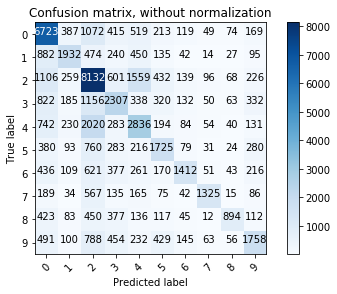

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(expected_output_test, pred_data)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = emoji.icons.unique(),
                      title='Confusion matrix, without normalization')